In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, cross_val_predict
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, accuracy_score

In [2]:
df = pd.read_csv('../data_clean/AA_Supervised_dataset.csv')
df.head()

,afspraak_Arbeidsmarkt,afspraak_Bedrijfsbeheer,afspraak_Duurzaamheid,afspraak_Familiebedrijfsmanagement,afspraak_Financieel,afspraak_Groeien en Netwerking,afspraak_Internationaal Ondernemen,afspraak_Lidmaatschap,afspraak_Logistiek en Transport,afspraak_Plato & Bryo,...,4,5,0_campagne_type,1_campagne_type,2_campagne_type,3_campagne_type,4_campagne_type,5_campagne_type,Online,Offline
0,0,0,0,0,0,0,0,1,0,0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1
1,0,0,0,0,0,0,0,1,0,0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1
2,0,0,0,0,0,0,0,1,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1
3,0,0,0,0,0,0,0,1,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1
4,0,0,0,0,0,0,0,1,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 54 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   afspraak_Arbeidsmarkt               300000 non-null  int64  
 1   afspraak_Bedrijfsbeheer             300000 non-null  int64  
 2   afspraak_Duurzaamheid               300000 non-null  int64  
 3   afspraak_Familiebedrijfsmanagement  300000 non-null  int64  
 4   afspraak_Financieel                 300000 non-null  int64  
 5   afspraak_Groeien en Netwerking      300000 non-null  int64  
 6   afspraak_Internationaal Ondernemen  300000 non-null  int64  
 7   afspraak_Lidmaatschap               300000 non-null  int64  
 8   afspraak_Logistiek en Transport     300000 non-null  int64  
 9   afspraak_Plato & Bryo               300000 non-null  int64  
 10  afspraak_Technologie en Innovatie   300000 non-null  int64  
 11  afspraak_Welt             

In [3]:
# opsplitting in X en y
X = df.drop('ingeschreven', axis=1)
y = df['ingeschreven']

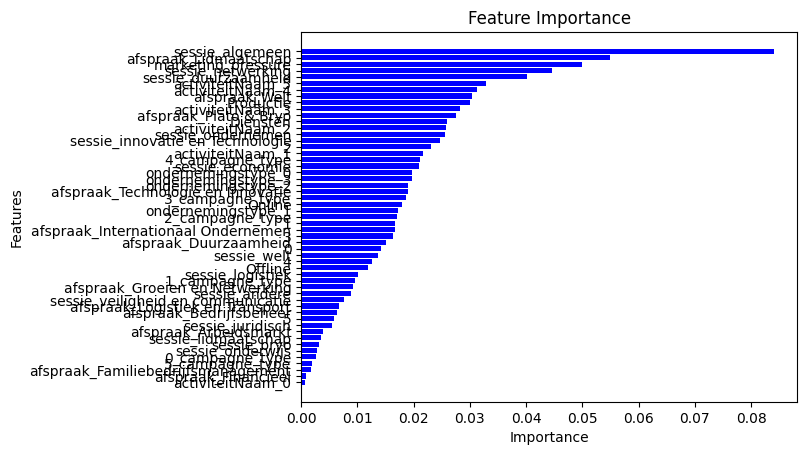

<Figure size 1500x1500 with 0 Axes>

In [55]:
# Checking feature importance
forest_clf = RandomForestClassifier(random_state=42, n_estimators=500, n_jobs=-1)
forest_clf.fit(X, y)

importances = forest_clf.feature_importances_
featureNames = X.columns

features = pd.DataFrame({'feature': featureNames, 'importance': importances})
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

plt.barh(features.index, features['importance'], color='b')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.figure(figsize=(15, 15))
plt.show()

In [4]:
# opsplitting in train en test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=df['ingeschreven'])
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((210000, 53), (90000, 53), (210000,), (90000,))

In [5]:
def models_gs(model):
    try:
        grid_search = GridSearchCV(model["model"], param_grid=model["param_grid"], cv=5, scoring="accuracy", return_train_score=True, n_jobs=-1)
        grid_search.fit(X_train, y_train)
    
        best_model = grid_search.best_estimator_
        return (best_model, grid_search.best_score_)
    
    except Exception as e:
        print(f"{model['name']} failed with error: {e}")

In [58]:
non_ensemble_models_param_grid = [
   {
      "name":"linearsvc",
      "model": LinearSVC(random_state=42),
      "param_grid": {
         "C":[0.1, 0.5, 1, 2.5, 5, 10, 20, 50, 75, 100, 125, 150, 200, 250, 500, 1000],
         "penalty": ["l2"],
         "loss": ["loss", "log_loss", "hinge", "squared_hinge"],
      }
   },
   {
      "name":"sgdclassifier",
      "model": SGDClassifier(random_state=42),
      "param_grid":{
         "alpha":[0.001, 0.01, 0.1, 0.5, 1],
         "penalty":["l2"],
         "max_iter": [1000],
         "loss": ["log_loss"]
      }
   },
   {
      "name":"logisticregression",
      "model": LogisticRegression(random_state=42, max_iter=1000),
      "param_grid":{
         "C":[0.1, 0.5, 1, 2.5, 5, 10, 20, 50, 75, 100, 125, 150, 200, 250, 500, 1000],
         "penalty":["l2"]
      }
   },
   {
      "name":"decisiontreeclassifier",
      "model": DecisionTreeClassifier(random_state=42),
      "param_grid":{
         "max_depth":[5, 10, 15, 20, 25, 30],
         "min_samples_split":[2, 5, 10, 15],
         "min_samples_leaf":[2, 5, 10, 15],
      }
   },
]

In [59]:
for model in non_ensemble_models_param_grid:
  print(f'Starting {model["name"]}...')
  gs = models_gs(model)
  print(gs)

Starting linearsvc...
(LinearSVC(C=20, random_state=42), 0.9166238095238096)
Starting sgdclassifier...
(SGDClassifier(alpha=0.001, loss='log_loss', random_state=42), 0.9160285714285715)
Starting logisticregression...
(LogisticRegression(C=0.1, max_iter=1000, random_state=42), 0.9171238095238096)
Starting decisiontreeclassifier...
(DecisionTreeClassifier(max_depth=30, min_samples_leaf=2, min_samples_split=5,
                       random_state=42), 0.9427523809523809)


In [6]:
best_models = [
  {
    'name': 'linearsvc',
    'model': LinearSVC(C=20, random_state=42)
  },
  {
    'name': 'sgdclassifier',
    'model': SGDClassifier(alpha=0.001, loss='log_loss', random_state=42)
  },
  {
    'name': 'logisticregression',
    'model': LogisticRegression(C=0.1, max_iter=1000, random_state=42)
  },
  {
    'name': 'deciciontreeclassifier',
    'model': DecisionTreeClassifier(max_depth=30, min_samples_leaf=2, min_samples_split=5, random_state=42)
  },
]

In [62]:
for model in best_models:
  cv_score = cross_val_score(model["model"], X_train, y_train, cv=5, scoring="accuracy", n_jobs=-1)
  print(f'{model["name"]} - cross validation scores: {np.mean(cv_score)}')

linearsvc - cross validation scores: 0.9166238095238096
sgdclassifier - cross validation scores: 0.9160285714285715
logisticregression - cross validation scores: 0.9171238095238096
deciciontreeclassifier - cross validation scores: 0.9427523809523809


In [63]:
rfc = {
      "name":"randomforestclassifier",
      "model": RandomForestClassifier(random_state=42, n_jobs=-1),
      "param_grid":{
         "n_estimators":[50, 75, 100, 125, 150, 175, 200],
         "min_samples_split":[2, 5, 10],
         "min_samples_leaf":[2, 5, 10],
      }
    }

In [64]:
print(f"Starting {rfc['name']}...")
gs = models_gs(rfc)
print(gs)

Starting randomforestclassifier...
(RandomForestClassifier(min_samples_leaf=2, n_estimators=150, n_jobs=-1,
                       random_state=42), 0.9460809523809524)


In [7]:
best_models.append({
  'name': 'randomforestclassifier',
  'model': RandomForestClassifier(min_samples_leaf=2, n_estimators=150, n_jobs=-1, random_state=42)
})

In [71]:
voting_clfs = [
    {
        "name": "votingclassifier",
        "diff": "hard",
        "model": VotingClassifier(estimators=[
            ('linsvc', best_models[0]['model']),
            ('sgd', best_models[1]['model']),
            ('lr', best_models[2]['model']),
            ('dt', best_models[3]['model']),
            ('rf', best_models[4]['model']),
        ], voting='hard', n_jobs=-1),
        "param_grid": {
            'weights': [
                [1, 1, 1, 1, 1],
                [1, 1, 1, 1, 2], 
                [1, 1, 1, 2, 2], 
                [1, 1, 2, 2, 2], 
                [1, 2, 2, 2, 2],
                [2, 2, 2, 2, 2]
            ]
        }
    },
    {
        "name": "votingclassifier",
        "diff": "soft",
        "model": VotingClassifier(estimators=[
            ('sgd', best_models[1]['model']),
            ('lr', best_models[2]['model']),
            ('dt', best_models[3]['model']),
            ('rf', best_models[4]['model']),
        ], voting='soft', n_jobs=-1),
        "param_grid": {
            'weights': [
                [1, 1, 1, 1], 
                [1, 1, 1, 2], 
                [1, 1, 2, 2], 
                [1, 2, 2, 2], 
                [2, 2, 2, 2]
            ]
        }
    }
]

In [72]:
for model in voting_clfs:
    print(f"Starting {model['diff']}-voting model...")
    gs = models_gs({
        "name": model["name"],
        "model": model["model"],
        "param_grid": model["param_grid"]
    })
    print(gs)

Starting hard-voting model...
(VotingClassifier(estimators=[('linsvc', LinearSVC(C=20, random_state=42)),
                             ('sgd',
                              SGDClassifier(alpha=0.001, loss='log_loss',
                                            random_state=42)),
                             ('lr',
                              LogisticRegression(C=0.1, max_iter=1000,
                                                 random_state=42)),
                             ('dt',
                              DecisionTreeClassifier(max_depth=30,
                                                     min_samples_leaf=2,
                                                     min_samples_split=5,
                                                     random_state=42)),
                             ('rf',
                              RandomForestClassifier(min_samples_leaf=2,
                                                     n_estimators=150,
                                           

In [8]:
best_models.append({
  "name": "votingclassifier_hard",
  "model": VotingClassifier(estimators=[('linsvc', LinearSVC(C=20, random_state=42)),
                             ('sgd',
                              SGDClassifier(alpha=0.001, loss='log_loss',
                                            random_state=42)),
                             ('lr',
                              LogisticRegression(C=0.1, max_iter=1000,
                                                 random_state=42)),
                             ('dt',
                              DecisionTreeClassifier(max_depth=30,
                                                     min_samples_leaf=2,
                                                     min_samples_split=5,
                                                     random_state=42)),
                             ('rf',
                              RandomForestClassifier(min_samples_leaf=2,
                                                     n_estimators=150,
                                                     n_jobs=-1,
                                                     random_state=42))],
                 n_jobs=-1, weights=[1, 1, 1, 2, 2])
})

best_models.append({
  "name": "votingclassifier_soft",
  "model": VotingClassifier(estimators=[('sgd',
                              SGDClassifier(alpha=0.001, loss='log_loss',
                                            random_state=42)),
                             ('lr',
                              LogisticRegression(C=0.1, max_iter=1000,
                                                 random_state=42)),
                             ('dt',
                              DecisionTreeClassifier(max_depth=30,
                                                     min_samples_leaf=2,
                                                     min_samples_split=5,
                                                     random_state=42)),
                             ('rf',
                              RandomForestClassifier(min_samples_leaf=2,
                                                     n_estimators=150,
                                                     n_jobs=-1,
                                                     random_state=42))],
                 n_jobs=-1, voting='soft', weights=[1, 1, 2, 2])
})

In [78]:
bagging_clf = {
    "name": 'BaggingClassifier',
    "model": BaggingClassifier(random_state=42, n_jobs=-1, oob_score=True),
    "param_grid": {
        "base_estimator": [best_models[3]["model"]],
        "n_estimators": [10, 50, 100, 150],
        "bootstrap": [True, False],
        "max_samples": [0.5, 1.0, 2.0, 5.0]
    }
}

In [79]:
print(f"Starting {bagging_clf['name']}...")
gs = models_gs(bagging_clf)
print(gs)

Starting BaggingClassifier...
(BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=30,
                                                        min_samples_leaf=2,
                                                        min_samples_split=5,
                                                        random_state=42),
                  n_estimators=100, n_jobs=-1, oob_score=True, random_state=42), 0.9457380952380952)


In [10]:
best_models.append({
  "name": "BaggingClassifier",
  "model": BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=30,
                                                        min_samples_leaf=2,
                                                        min_samples_split=5,
                                                        random_state=42),
                  n_estimators=100, n_jobs=-1, oob_score=True, random_state=42)
})

In [82]:
adaboost_clf = {
    "name": 'AdaBoostClassifier',
    "model": AdaBoostClassifier(random_state=42),
    "param_grid": {
        "base_estimator": [best_models[3]["model"]],
        "n_estimators": [10, 50, 100, 150],
        "learning_rate": [0.1, 0.5, 1.0, 2.0],
        "algorithm": ['SAMME.R']
    }
}

In [83]:
print(f"Starting {adaboost_clf['name']}...")
gs = models_gs(adaboost_clf)
print(gs)

Starting AdaBoostClassifier...
(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=30,
                                                         min_samples_leaf=2,
                                                         min_samples_split=5,
                                                         random_state=42),
                   learning_rate=0.5, n_estimators=150, random_state=42), 0.9474)


In [11]:
best_models.append({
  "name": "AdaBoostClassifier",
  "model": AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=30,
                                                         min_samples_leaf=2,
                                                         min_samples_split=5,
                                                         random_state=42),
                   learning_rate=0.5, n_estimators=150, random_state=42)
})

In [85]:
gradient_boosting_clf = {
    "name": 'GradientBoostingClassifier',
    "model": GradientBoostingClassifier(random_state=42),
    "param_grid": {
        "n_estimators": [10, 50, 100, 150],
        "learning_rate": [0.1, 0.5, 1.0, 2.0],
        "min_samples_split": [2, 5, 10],
    }
}

In [86]:
print(f"Starting {gradient_boosting_clf['name']}...")
gs = models_gs(gradient_boosting_clf)
print(gs)

Starting GradientBoostingClassifier...
(GradientBoostingClassifier(learning_rate=0.5, min_samples_split=5,
                           n_estimators=150, random_state=42), 0.9322571428571429)


In [12]:
best_models.append({
  "name": "GradientBoostingClassifier",
  "model": GradientBoostingClassifier(learning_rate=0.5, min_samples_split=5,
                           n_estimators=150, random_state=42)
})

In [13]:
estimators = [
    ('sgd', best_models[1]['model']),
    ('lr', best_models[2]['model']),
    ('dt', best_models[3]['model']),
    ('rf', best_models[4]['model']),
]

final_estimators = [
    ('sgd', SGDClassifier(random_state=42, loss='log_loss')),
    ('lr', LogisticRegression(random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42)),
]

stacking_clfs = [
    {
        "name": 'StackingClassifier',
        "diff": final_estimators[0][0],
        "model": StackingClassifier(estimators=estimators, final_estimator=final_estimators[0][1], n_jobs=-1),
        "param_grid": {}
    },
    {
        "name": 'StackingClassifier',
        "diff": final_estimators[1][0],
        "model": StackingClassifier(estimators=estimators, final_estimator=final_estimators[1][1], n_jobs=-1),
        "param_grid": {}
    },
    {
        "name": 'StackingClassifier',
        "diff": final_estimators[2][0],
        "model": StackingClassifier(estimators=estimators, final_estimator=final_estimators[2][1], n_jobs=-1),
        "param_grid": {}
    },
    {
        "name": 'StackingClassifier',
        "diff": final_estimators[3][0],
        "model": StackingClassifier(estimators=estimators, final_estimator=final_estimators[3][1], n_jobs=-1),
        "param_grid": {}
    }
]

In [14]:
for i in stacking_clfs:
    print(f"Starting {i['name']}_{i['diff']}...")
    gs = models_gs(i)
    print(gs)

Starting StackingClassifier_sgd...
(StackingClassifier(estimators=[('sgd',
                                SGDClassifier(alpha=0.001, loss='log_loss',
                                              random_state=42)),
                               ('lr',
                                LogisticRegression(C=0.1, max_iter=1000,
                                                   random_state=42)),
                               ('dt',
                                DecisionTreeClassifier(max_depth=30,
                                                       min_samples_leaf=2,
                                                       min_samples_split=5,
                                                       random_state=42)),
                               ('rf',
                                RandomForestClassifier(min_samples_leaf=2,
                                                       n_estimators=150,
                                                       n_jobs=-1,
                   

In [15]:
best_models.append({
  "name": "StackingClassifier_sgd",
  "model": StackingClassifier(estimators=[('sgd',
                                SGDClassifier(alpha=0.001, loss='log_loss',
                                              random_state=42)),
                               ('lr',
                                LogisticRegression(C=0.1, max_iter=1000,
                                                   random_state=42)),
                               ('dt',
                                DecisionTreeClassifier(max_depth=30,
                                                       min_samples_leaf=2,
                                                       min_samples_split=5,
                                                       random_state=42)),
                               ('rf',
                                RandomForestClassifier(min_samples_leaf=2,
                                                       n_estimators=150,
                                                       n_jobs=-1,
                                                       random_state=42))],
                   final_estimator=SGDClassifier(loss='log_loss',
                                                 random_state=42),
                   n_jobs=-1)
})
best_models.append({
  "name": "StackingClassifier_lr",
  "model": StackingClassifier(estimators=[('sgd',
                                SGDClassifier(alpha=0.001, loss='log_loss',
                                              random_state=42)),
                               ('lr',
                                LogisticRegression(C=0.1, max_iter=1000,
                                                   random_state=42)),
                               ('dt',
                                DecisionTreeClassifier(max_depth=30,
                                                       min_samples_leaf=2,
                                                       min_samples_split=5,
                                                       random_state=42)),
                               ('rf',
                                RandomForestClassifier(min_samples_leaf=2,
                                                       n_estimators=150,
                                                       n_jobs=-1,
                                                       random_state=42))],
                   final_estimator=LogisticRegression(random_state=42),
                   n_jobs=-1)
})
best_models.append({
  "name": "StackingClassifier",
  "model": StackingClassifier(estimators=[('sgd',
                                SGDClassifier(alpha=0.001, loss='log_loss',
                                              random_state=42)),
                               ('lr',
                                LogisticRegression(C=0.1, max_iter=1000,
                                                   random_state=42)),
                               ('dt',
                                DecisionTreeClassifier(max_depth=30,
                                                       min_samples_leaf=2,
                                                       min_samples_split=5,
                                                       random_state=42)),
                               ('rf',
                                RandomForestClassifier(min_samples_leaf=2,
                                                       n_estimators=150,
                                                       n_jobs=-1,
                                                       random_state=42))],
                   final_estimator=DecisionTreeClassifier(random_state=42),
                   n_jobs=-1)
})
best_models.append({
  "name": "StackingClassifier_rf",
  "model": StackingClassifier(estimators=[('sgd',
                                SGDClassifier(alpha=0.001, loss='log_loss',
                                              random_state=42)),
                               ('lr',
                                LogisticRegression(C=0.1, max_iter=1000,
                                                   random_state=42)),
                               ('dt',
                                DecisionTreeClassifier(max_depth=30,
                                                       min_samples_leaf=2,
                                                       min_samples_split=5,
                                                       random_state=42)),
                               ('rf',
                                RandomForestClassifier(min_samples_leaf=2,
                                                       n_estimators=150,
                                                       n_jobs=-1,
                                                       random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1)
})

In [16]:
# Train best models
for model in best_models:
    print(f"Training {model['name']}...")
    model['model'].fit(X_train, y_train)
    print(f"Training {model['name']} done!")

Training linearsvc...
Training linearsvc done!
Training sgdclassifier...
Training sgdclassifier done!
Training logisticregression...
Training logisticregression done!
Training deciciontreeclassifier...
Training deciciontreeclassifier done!
Training randomforestclassifier...
Training randomforestclassifier done!
Training votingclassifier_hard...
Training votingclassifier_hard done!
Training votingclassifier_soft...
Training votingclassifier_soft done!
Training BaggingClassifier...
Training BaggingClassifier done!
Training AdaBoostClassifier...
Training AdaBoostClassifier done!
Training GradientBoostingClassifier...
Training GradientBoostingClassifier done!
Training StackingClassifier_sgd...
Training StackingClassifier_sgd done!
Training StackingClassifier_lr...
Training StackingClassifier_lr done!
Training StackingClassifier...
Training StackingClassifier done!
Training StackingClassifier_rf...
Training StackingClassifier_rf done!


## Dataframe for later comparison

In [19]:
model_comparison = ["Name", "cv_score", "precision", "recall", "f1", "roc_auc"]

In [22]:
for model in best_models:
    print(f"Starting {model['name']}...")
    scores = cross_val_score(model["model"], X_train, y_train, cv=5, scoring="accuracy", n_jobs=-1)
    y_train_pred = cross_val_predict(model["model"], X_train, y_train, cv=5, n_jobs=-1)

    precision = precision_score(y_train, y_train_pred)
    recall = recall_score(y_train, y_train_pred)
    f1 = f1_score(y_train, y_train_pred)
    roc_auc = roc_auc_score(y_train, y_train_pred)

    model_comparison.append({
        "Name": model["name"],
        "cv_score": scores.mean(),
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc
    })

Starting {model['name']}...
Starting {model['name']}...
Starting {model['name']}...
Starting {model['name']}...
Starting {model['name']}...
Starting {model['name']}...
Starting {model['name']}...
Starting {model['name']}...
Starting {model['name']}...
Starting {model['name']}...
Starting {model['name']}...
Starting {model['name']}...
Starting {model['name']}...
Starting {model['name']}...


In [23]:
model_comparison

['Name',
 'cv_score',
 'precision',
 'recall',
 'f1',
 'roc_auc',
 {'Name': 'linearsvc',
  'cv_score': 0.9166238095238096,
  'precision': 0.6253698224852071,
  'recall': 0.09297850112717876,
  'f1': 0.16188789430855394,
  'roc_auc': 0.5438486579030294},
 {'Name': 'sgdclassifier',
  'cv_score': 0.9160285714285715,
  'precision': 0.5992818671454219,
  'recall': 0.0917688458789245,
  'f1': 0.1591646004196071,
  'roc_auc': 0.5429753396135145},
 {'Name': 'logisticregression',
  'cv_score': 0.9171238095238096,
  'precision': 0.5818866345952729,
  'recall': 0.1529664045746962,
  'f1': 0.24225008707767326,
  'roc_auc': 0.5712723980144364},
 {'Name': 'deciciontreeclassifier',
  'cv_score': 0.9427523809523809,
  'precision': 0.7289268473821018,
  'recall': 0.5396711937097927,
  'f1': 0.6201819790218628,
  'roc_auc': 0.7603211218193149},
 {'Name': 'randomforestclassifier',
  'cv_score': 0.9460809523809524,
  'precision': 0.8279189757309383,
  'recall': 0.4764392148237752,
  'f1': 0.60482322967926

In [28]:
# make a dataframe of the model comparison
model_comparison_df = pd.DataFrame(model_comparison)
model_comparison_df

,Name,cv_score,precision,recall,f1,roc_auc
0,linearsvc,0.916624,0.625370,0.092979,0.161888,0.543849
1,sgdclassifier,0.916029,0.599282,0.091769,0.159165,0.542975
2,logisticregression,0.917124,0.581887,0.152966,0.242250,0.571272
3,deciciontreeclassifier,0.942752,0.728927,0.539671,0.620182,0.760321
4,randomforestclassifier,0.946081,0.827919,0.476439,0.604823,0.733525
5,votingclassifier_hard,0.945552,0.824009,0.472150,0.600322,0.731295
6,votingclassifier_soft,0.943433,0.836319,0.431242,0.569055,0.711620
7,BaggingClassifier,0.945738,0.757273,0.549623,0.636952,0.766460
8,AdaBoostClassifier,0.947400,0.763020,0.569528,0.652226,0.776378
9,GradientBoostingClassifier,0.932257,0.751556,0.325342,0.454106,0.657572


In [29]:
model_comparison.sort_values(by="precision", ascending=False)

AttributeError: 'list' object has no attribute 'sort_values'

In [34]:
model_comparison_test = []

In [31]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.figure(figsize=(6, 5))
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--', label="Random classifier's ROC curve")
  plt.title(f"{label} - Test")
  plt.legend(loc="lower right", fontsize=13)
  plt.xlabel("True Positive Rate (Recall)")
  plt.ylabel("False Positive Rate (Fall-Out)")
  plt.grid(True)
  plt.axis([0, 1, 0, 1])
  plt.figure(figsize=(10,5))

<Figure size 640x480 with 0 Axes>

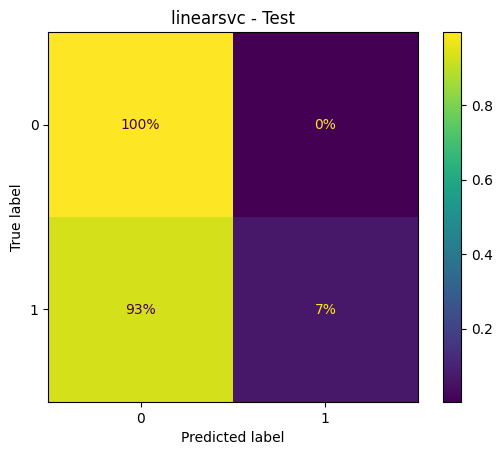

<Figure size 640x480 with 0 Axes>

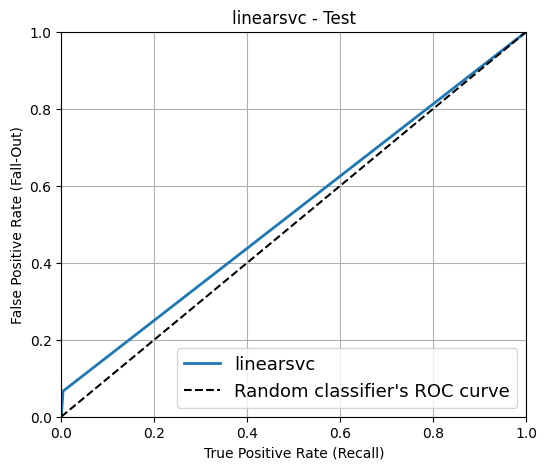

<Figure size 1000x500 with 0 Axes>

linearsvc - Test
Accuracy: 0.9157
Precision: 0.6248492159227985
Recall: 0.06646138054914036
F1: 0.12014380146120839
ROC AUC: 0.5313391008528734
***************************************************************************


<Figure size 640x480 with 0 Axes>

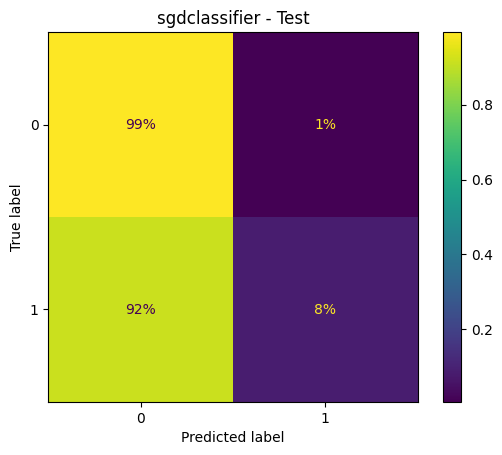

<Figure size 640x480 with 0 Axes>

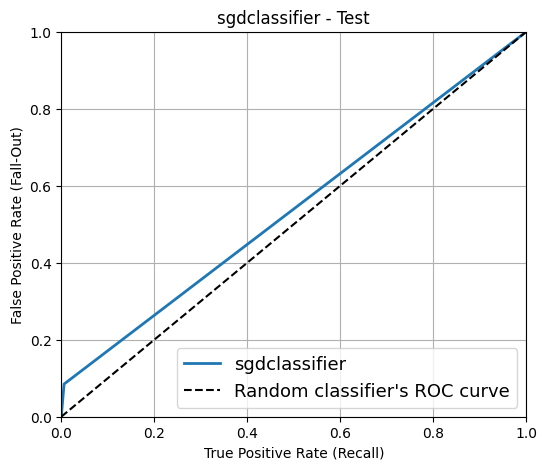

<Figure size 1000x500 with 0 Axes>

sgdclassifier - Test
Accuracy: 0.9152777777777777
Precision: 0.5732870771899393
Recall: 0.08480882730305363
F1: 0.14775902537163293
ROC AUC: 0.5394119313509648
***************************************************************************


<Figure size 640x480 with 0 Axes>

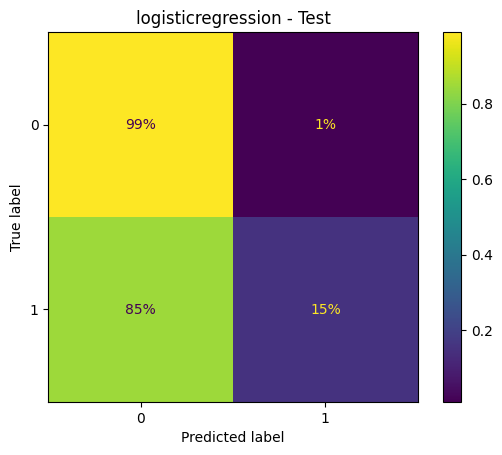

<Figure size 640x480 with 0 Axes>

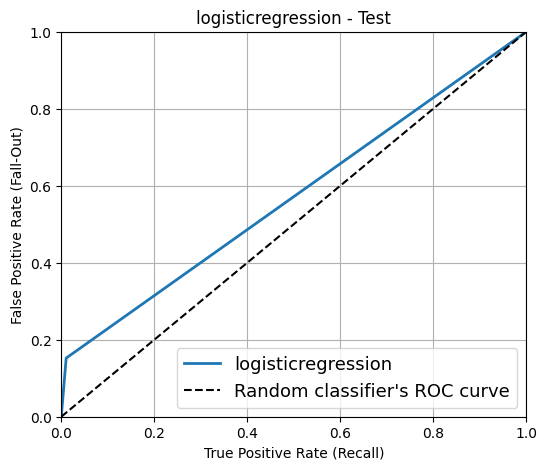

<Figure size 1000x500 with 0 Axes>

logisticregression - Test
Accuracy: 0.9169444444444445
Precision: 0.5776155717761557
Recall: 0.1522966384398255
F1: 0.24103969946187428
ROC AUC: 0.5708688992262383
***************************************************************************


<Figure size 640x480 with 0 Axes>

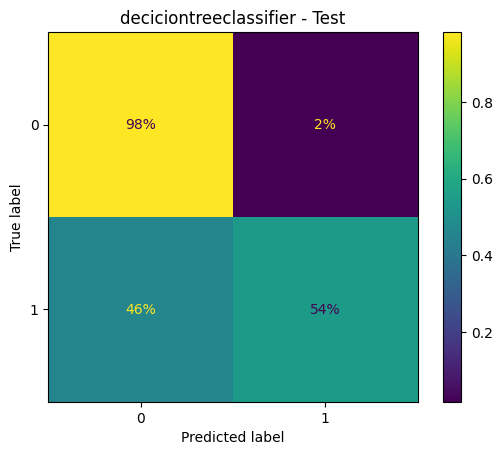

<Figure size 640x480 with 0 Axes>

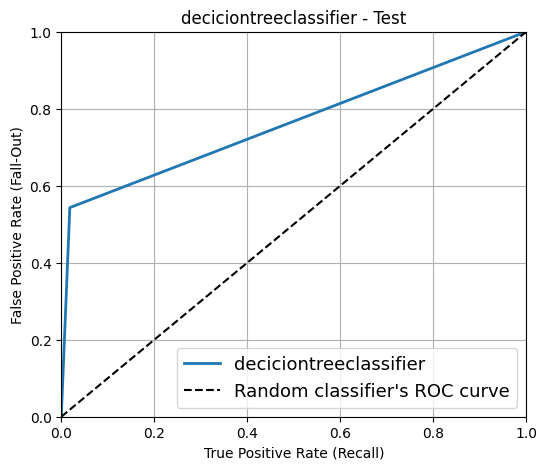

<Figure size 1000x500 with 0 Axes>

deciciontreeclassifier - Test
Accuracy: 0.9436777777777777
Precision: 0.7373279916390872
Recall: 0.5431100846805235
F1: 0.6254894717399334
ROC AUC: 0.7623829624434172
***************************************************************************


<Figure size 640x480 with 0 Axes>

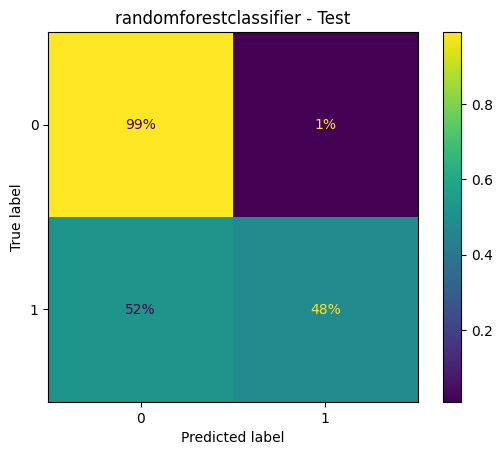

<Figure size 640x480 with 0 Axes>

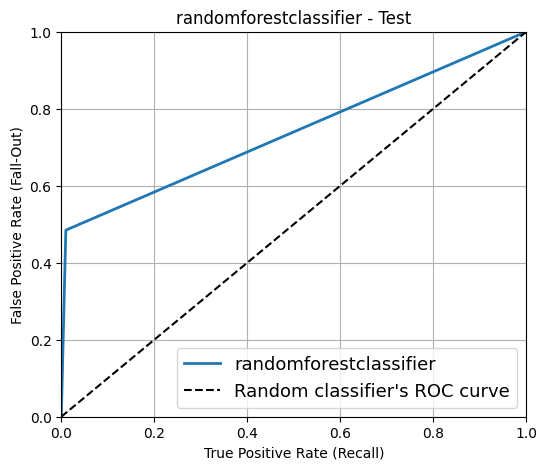

<Figure size 1000x500 with 0 Axes>

randomforestclassifier - Test
Accuracy: 0.9464222222222223
Precision: 0.8243125272806635
Recall: 0.48460354118552734
F1: 0.6103749191984486
ROC AUC: 0.7374055343083076
***************************************************************************


<Figure size 640x480 with 0 Axes>

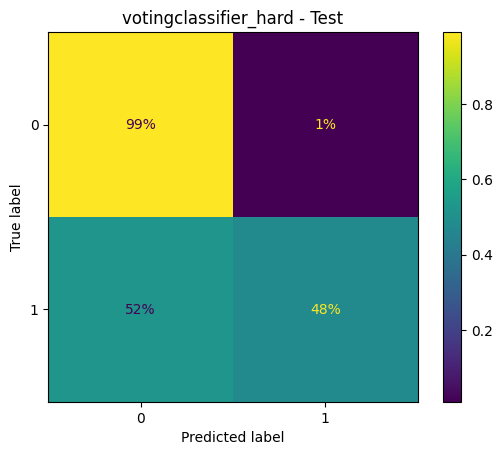

<Figure size 640x480 with 0 Axes>

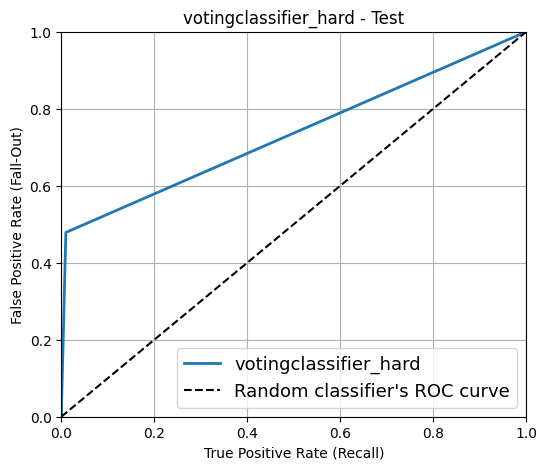

<Figure size 1000x500 with 0 Axes>

votingclassifier_hard - Test
Accuracy: 0.9458888888888889
Precision: 0.822310405643739
Recall: 0.4785732614831922
F1: 0.6050283860502839
ROC AUC: 0.7343843121760413
***************************************************************************


<Figure size 640x480 with 0 Axes>

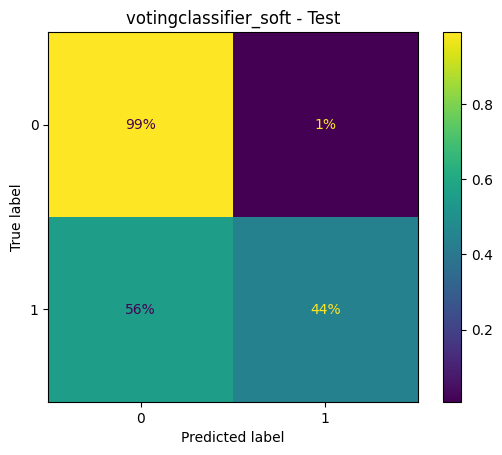

<Figure size 640x480 with 0 Axes>

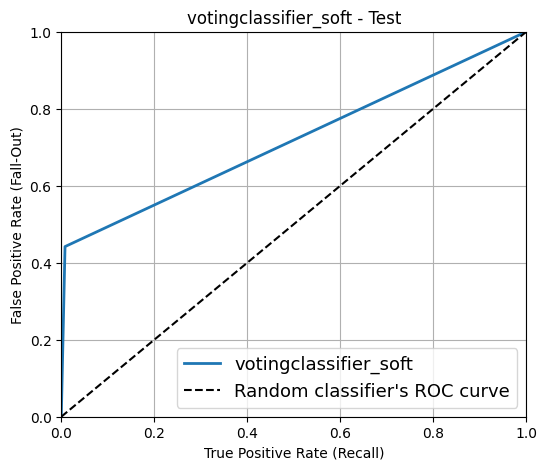

<Figure size 1000x500 with 0 Axes>

votingclassifier_soft - Test
Accuracy: 0.9443111111111111
Precision: 0.8387725280077934
Recall: 0.44187836797536567
F1: 0.5788235294117647
ROC AUC: 0.7169127139003413
***************************************************************************


<Figure size 640x480 with 0 Axes>

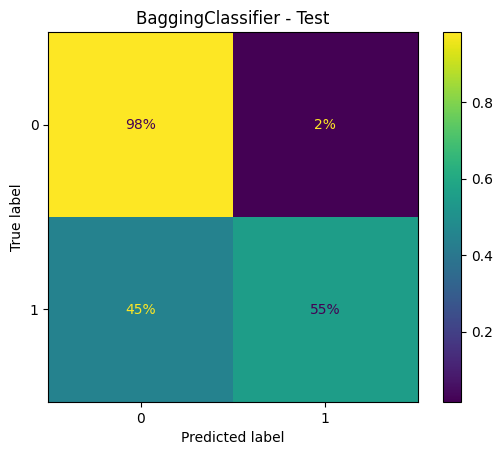

<Figure size 640x480 with 0 Axes>

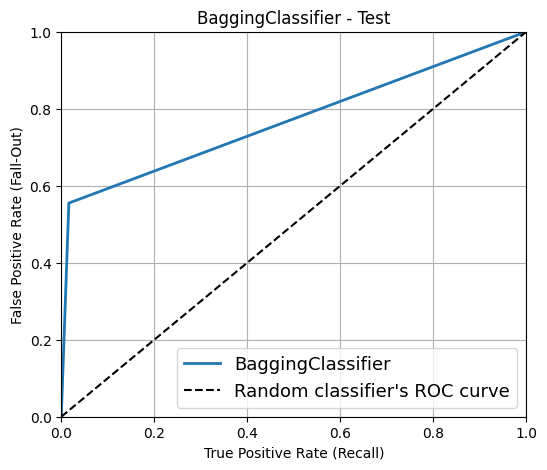

<Figure size 1000x500 with 0 Axes>

BaggingClassifier - Test
Accuracy: 0.9466111111111111
Precision: 0.7639992934110581
Recall: 0.5549140364382859
F1: 0.6428836863619471
ROC AUC: 0.7693310906712754
***************************************************************************


<Figure size 640x480 with 0 Axes>

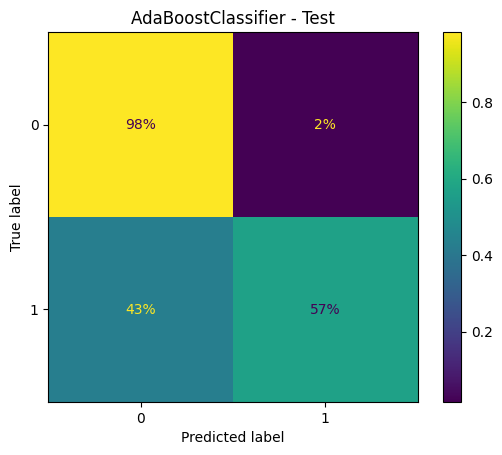

<Figure size 640x480 with 0 Axes>

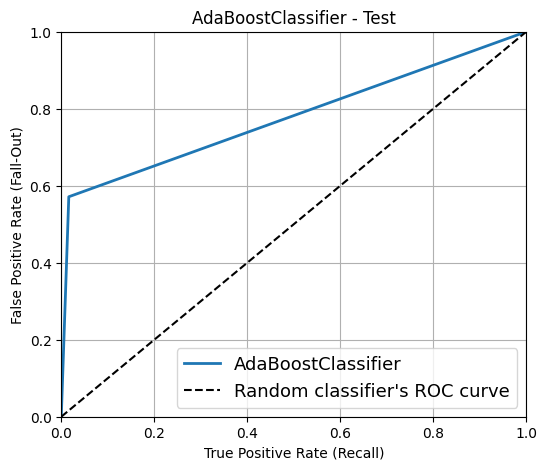

<Figure size 1000x500 with 0 Axes>

AdaBoostClassifier - Test
Accuracy: 0.9481111111111111
Precision: 0.7701487374610861
Recall: 0.5713369258403901
F1: 0.6560106069534473
ROC AUC: 0.7775851113400185
***************************************************************************


<Figure size 640x480 with 0 Axes>

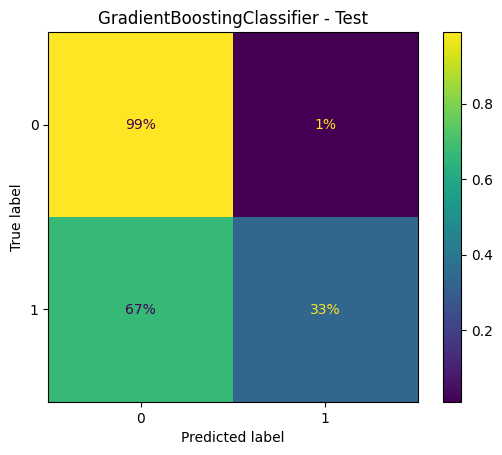

<Figure size 640x480 with 0 Axes>

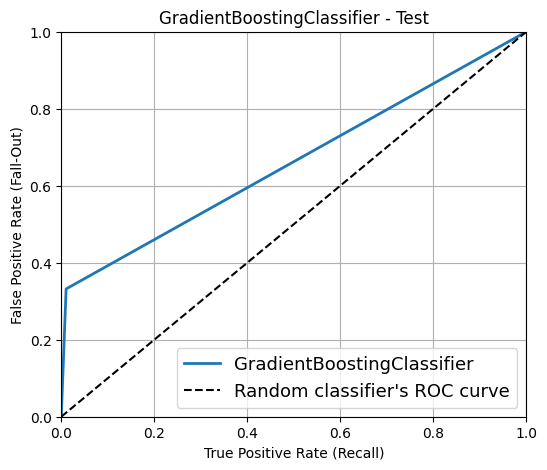

<Figure size 1000x500 with 0 Axes>

GradientBoostingClassifier - Test
Accuracy: 0.9326444444444445
Precision: 0.7515979081929111
Recall: 0.33192199127534
F1: 0.46048415806336773
ROC AUC: 0.6607606452982787
***************************************************************************


<Figure size 640x480 with 0 Axes>

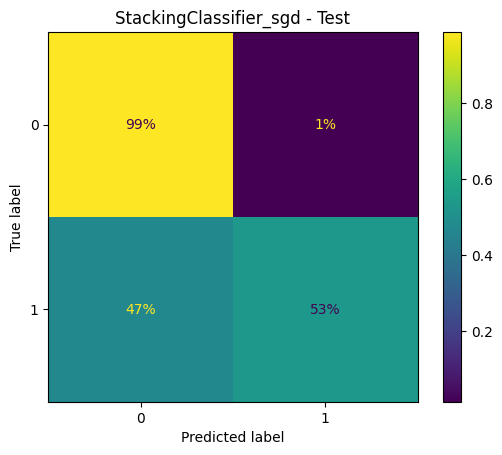

<Figure size 640x480 with 0 Axes>

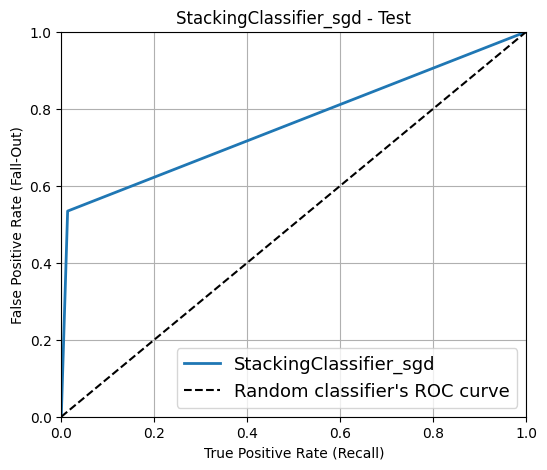

<Figure size 1000x500 with 0 Axes>

StackingClassifier_sgd - Test
Accuracy: 0.9471777777777778
Precision: 0.7875520242149073
Recall: 0.5341288170387477
F1: 0.6365443425076452
ROC AUC: 0.7602340068455302
***************************************************************************


<Figure size 640x480 with 0 Axes>

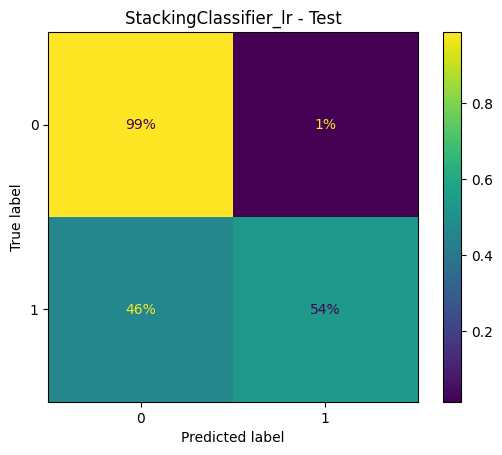

<Figure size 640x480 with 0 Axes>

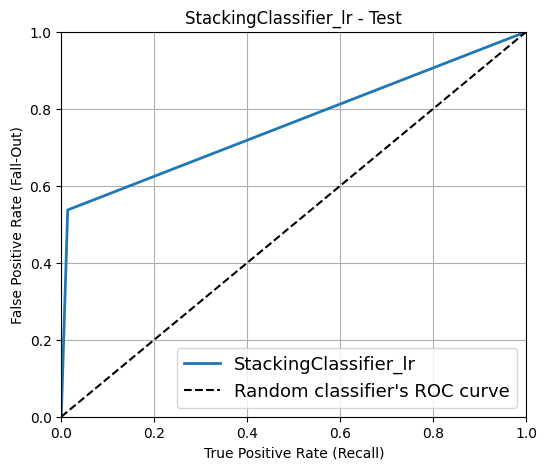

<Figure size 1000x500 with 0 Axes>

StackingClassifier_lr - Test
Accuracy: 0.9472888888888888
Precision: 0.7865464111236378
Recall: 0.5370798049781883
F1: 0.6383043610856968
ROC AUC: 0.7616304311609673
***************************************************************************


<Figure size 640x480 with 0 Axes>

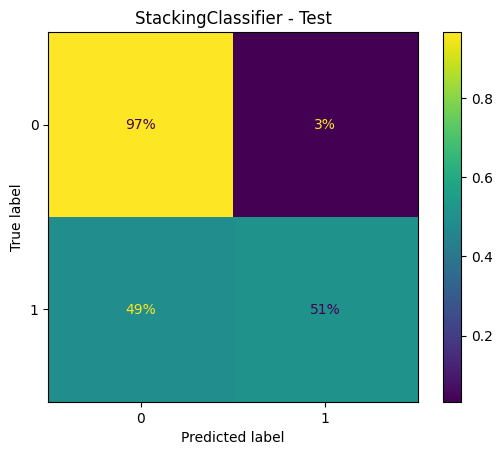

<Figure size 640x480 with 0 Axes>

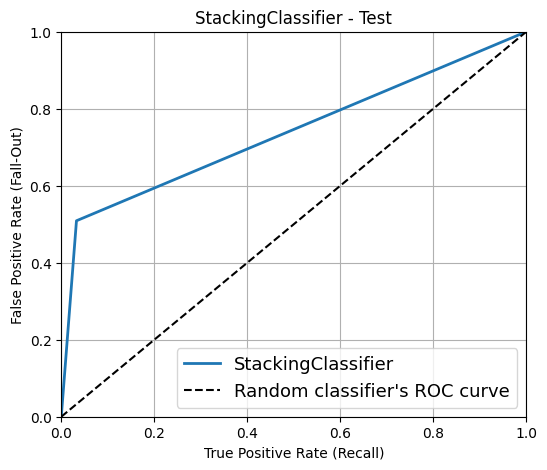

<Figure size 1000x500 with 0 Axes>

StackingClassifier - Test
Accuracy: 0.9276333333333333
Precision: 0.5962723583345859
Recall: 0.5089812676417758
F1: 0.5491797605039109
ROC AUC: 0.7381536267897709
***************************************************************************


<Figure size 640x480 with 0 Axes>

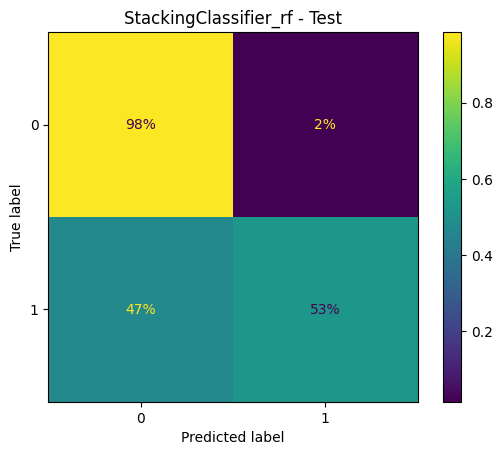

<Figure size 640x480 with 0 Axes>

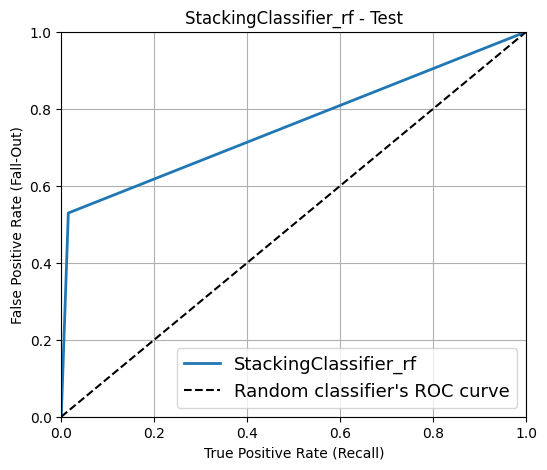

<Figure size 1000x500 with 0 Axes>

StackingClassifier_rf - Test
Accuracy: 0.9453888888888888
Precision: 0.7681132426895139
Recall: 0.5291249679240442
F1: 0.6266048773076047
ROC AUC: 0.7569900439941365
***************************************************************************


In [36]:
for model in best_models:
    y_test_pred = model["model"].predict(X_test)

    plt.figure()
    ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, normalize="true", values_format='.0%')
    plt.title(f"{model['name']} - Test")
    plt.show()

    score = accuracy_score(y_test, y_test_pred) 
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_pred)

    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
    plt.figure()
    plot_roc_curve(fpr, tpr, label=model["name"])
    plt.show()
    
    print(f"{model['name']} - Test")
    print(f"Accuracy: {score.mean()}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1: {f1}")
    print(f"ROC AUC: {roc_auc}")
    print(75 * "*")

    model_comparison_test.append({
        "Name": model["name"],
        "accuracy": score,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc
    })

In [37]:
model_comparison_test = pd.DataFrame(model_comparison_test)
model_comparison_test

,Name,accuracy,precision,recall,f1,roc_auc
0,linearsvc,0.915700,0.624849,0.066461,0.120144,0.531339
1,sgdclassifier,0.915278,0.573287,0.084809,0.147759,0.539412
2,logisticregression,0.916944,0.577616,0.152297,0.241040,0.570869
3,deciciontreeclassifier,0.943678,0.737328,0.543110,0.625489,0.762383
4,randomforestclassifier,0.946422,0.824313,0.484604,0.610375,0.737406
5,votingclassifier_hard,0.945889,0.822310,0.478573,0.605028,0.734384
6,votingclassifier_soft,0.944311,0.838773,0.441878,0.578824,0.716913
7,BaggingClassifier,0.946611,0.763999,0.554914,0.642884,0.769331
8,AdaBoostClassifier,0.948111,0.770149,0.571337,0.656011,0.777585
9,GradientBoostingClassifier,0.932644,0.751598,0.331922,0.460484,0.660761


In [39]:
import pickle as pkl

soft_voting = best_models[6]
filename = f'../models/epic3/{soft_voting["name"]}.pkl'
with open(filename, 'wb') as file:
    pkl.dump(soft_voting["model"], file)